In [ ]:
!nvidia-smi

Sun Jan 12 20:04:14 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install datasets &>> install.log
!pip install unet

In [ ]:
from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F
import os
from tqdm.notebook import tqdm
import torch
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import math
import matplotlib.pyplot as plt
import torch
import urllib
import PIL
from unet import UNet


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
IMAGE_SHAPE = (32, 32)

In [ ]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1),
])


reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2),
    transforms.Lambda(lambda t: t.permute(1, 2, 0)),
    transforms.Lambda(lambda t: t * 255.),
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
    transforms.ToPILImage(),
])

In [ ]:
def image_to_tensor(img: Image.Image) -> torch.Tensor:
    return torch.tensor(np.array(img.convert('RGB')) / 255.0).permute(2, 0, 1).unsqueeze(0) * 2 - 1


def tensor_to_image_conversion(tensor: torch.Tensor) -> Image.Image:
    image_array = np.array(((tensor.squeeze().permute(1, 2, 0) + 1) / 2).clip(0, 1) * 255).astype(np.uint8)
    return Image.fromarray(image_array)


def gather_tensor_values(constants: torch.Tensor, time: torch.Tensor) -> torch.Tensor:

    gathered_values = constants.gather(-1, time)
    return gathered_values.reshape(-1, 1, 1, 1)


## 2.1 Dataset

We'll start with a classic small dataset, with 32px square images from 10 classes. For convenience we just pull a version that is avalable on the huggingface hub.

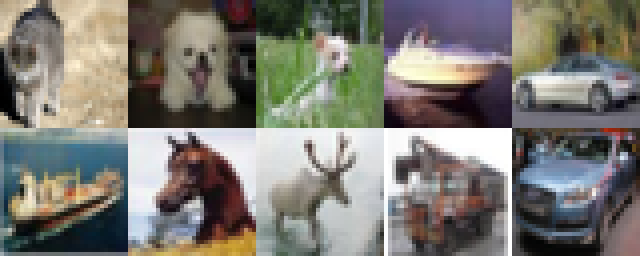

In [ ]:
cifar10_data = load_dataset('cifar10')

# Create a new image to display a grid of CIFAR-10 examples
grid_image = Image.new('RGB', size=(32 * 5, 32 * 2))

# Paste images into the grid
for idx in range(40):
    img = cifar10_data['train'][idx]['img']
    grid_image.paste(img, ((idx % 5) * 32,(idx // 20) * 32))

# Resize the image grid for better visibility
grid_image.resize((32 * 5 * 4, 32 * 2 * 4), Image.NEAREST)



In [ ]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

    def forward(self, x_0, t, device):

        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device)

    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):

        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]

        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)



In [ ]:
diffusion_model = DiffusionModel()


<Figure size 1500x1500 with 0 Axes>

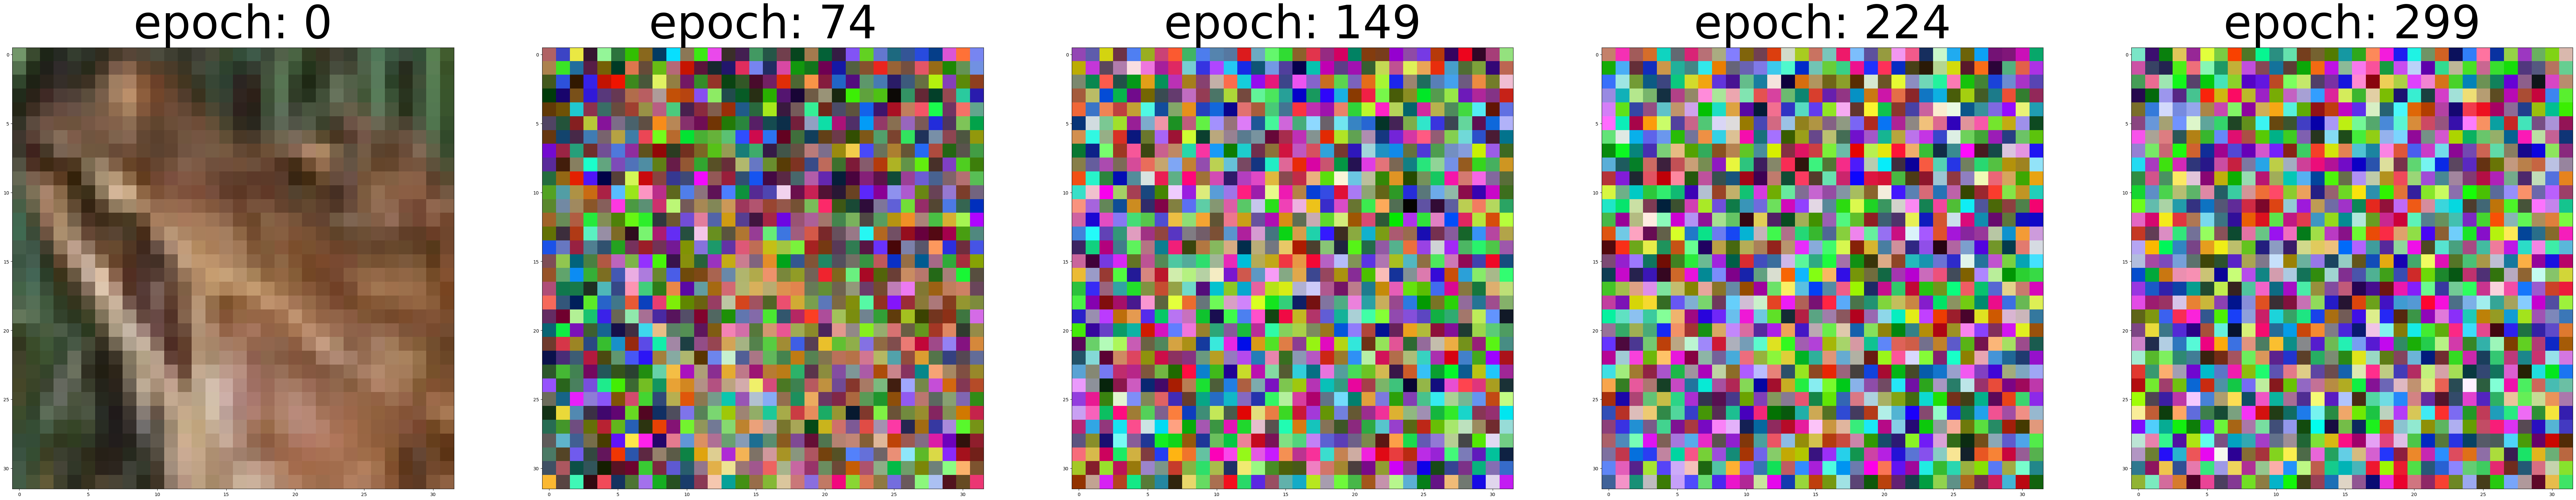

In [42]:
NO_DISPLAY_IMAGES = 5
start_im = cifar10_data['train'][57]['img']

torch_image_batch = torch.stack([transform(start_im)] * NO_DISPLAY_IMAGES)

t = torch.linspace(0, diffusion_model.timesteps - 1, NO_DISPLAY_IMAGES).long()
noisy_image_batch, _ = diffusion_model.forward(torch_image_batch, t, device)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(1, NO_DISPLAY_IMAGES, figsize = (100,100))

for idx, image in enumerate(noisy_image_batch):
    ax[idx].imshow(reverse_transform(image))
    ax[idx].set_title(f"epoch: {t[idx].item()}", fontsize = 100)
plt.show()

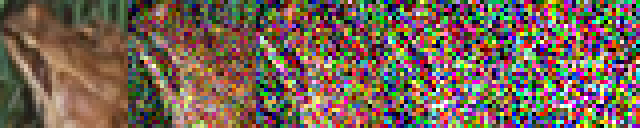

In [46]:
n_iterations = 100
alpha_values = torch.linspace(0.0001, 0.04, n_iterations).to(device)

import torch.distributions as distribution

def add_noise_to_image(image_previous, time_step):
    channels, height, width = image_previous.shape
    image_previous = image_previous.to(device)

    noise = torch.randn(channels, height, width).to(device)

    noisy_image = (1 - alpha_values[time_step]).sqrt().reshape(1, 1, 1) * image_previous + alpha_values[time_step].sqrt().reshape(1, 1, 1) * noise
    return noisy_image

# Initialize list to store images
generated_images = []
starting_image = cifar10_data['train'][57]['img']
tensor_image = image_to_tensor(starting_image).squeeze()

# Add noise at each time step and store images
for time_step in range(n_iterations):
    if time_step % 20 == 0:
        generated_images.append(tensor_to_image_conversion(tensor_image.cpu()))

    time_step_tensor = torch.tensor(time_step, dtype=torch.long)
    tensor_image = add_noise_to_image(tensor_image, time_step_tensor)

# Create a new image to display the generated images
image_grid = Image.new('RGB', size=(32 * 5, 32))
for index, generated_image in enumerate(generated_images):
    x_position = (index % 5) * 32
    image_grid.paste(generated_image, (x_position, 0))

image_grid.resize((32 * 4 * 5, 32 * 4), Image.NEAREST)


In [49]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()

        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)

        self.downsample = downsample

        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)

        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)

        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        o = self.bnorm1(self.relu(self.conv1(x)))
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time[(..., ) + (None, ) * 2]
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label[(..., ) + (None, ) * 2]

        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)


class UNet(nn.Module):
    def __init__(self, img_channels = 3, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)

        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)


    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)

        return self.conv2(o)

In [51]:

x = torch.randn(10, 3, 32, 32)

t = torch.tensor([50.], dtype=torch.long)
unet = UNet()

model_output = unet(x, t)

model_output.shape

torch.Size([10, 3, 32, 32])

In [84]:
unet = UNet(labels=False)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)

In [86]:
for epoch in range(1000):
    mean_epoch_loss = []

    # Apply transform to start_im and then stack
    transformed_image = transform(start_im)
    batch = torch.stack([transformed_image] * 128)

    t = torch.randint(0, diffusion_model.timesteps, (128,)).long().to(device)

    batch_noisy, noise = diffusion_model.forward(batch, t, device)
    predicted_noise = unet(batch_noisy, t)

    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(noise, predicted_noise)
    mean_epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()

    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")


---
Epoch: 0 | Train Loss 0.050410520285367966
---
Epoch: 400 | Train Loss 0.0115506611764431
---
Epoch: 800 | Train Loss 0.008942397311329842


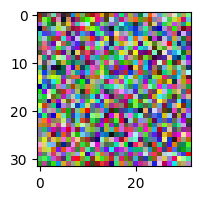

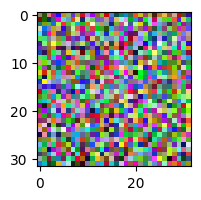

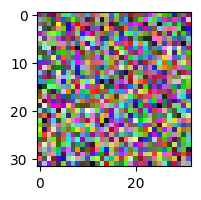

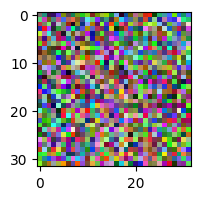

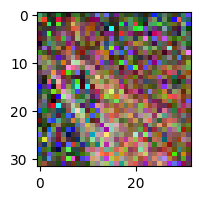

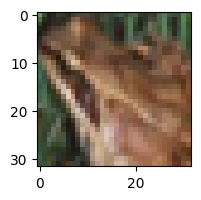

In [88]:
with torch.no_grad():
    img = torch.randn((1, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        img = diffusion_model.backward(img, t, unet.eval())
        if i % 50 == 0:
            plt.figure(figsize=(2,2))
            plt.imshow(reverse_transform(img[0]))
            plt.show()

In [90]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, drop_last=True)


100%|██████████| 170M/170M [00:02<00:00, 77.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Files already downloaded and verified


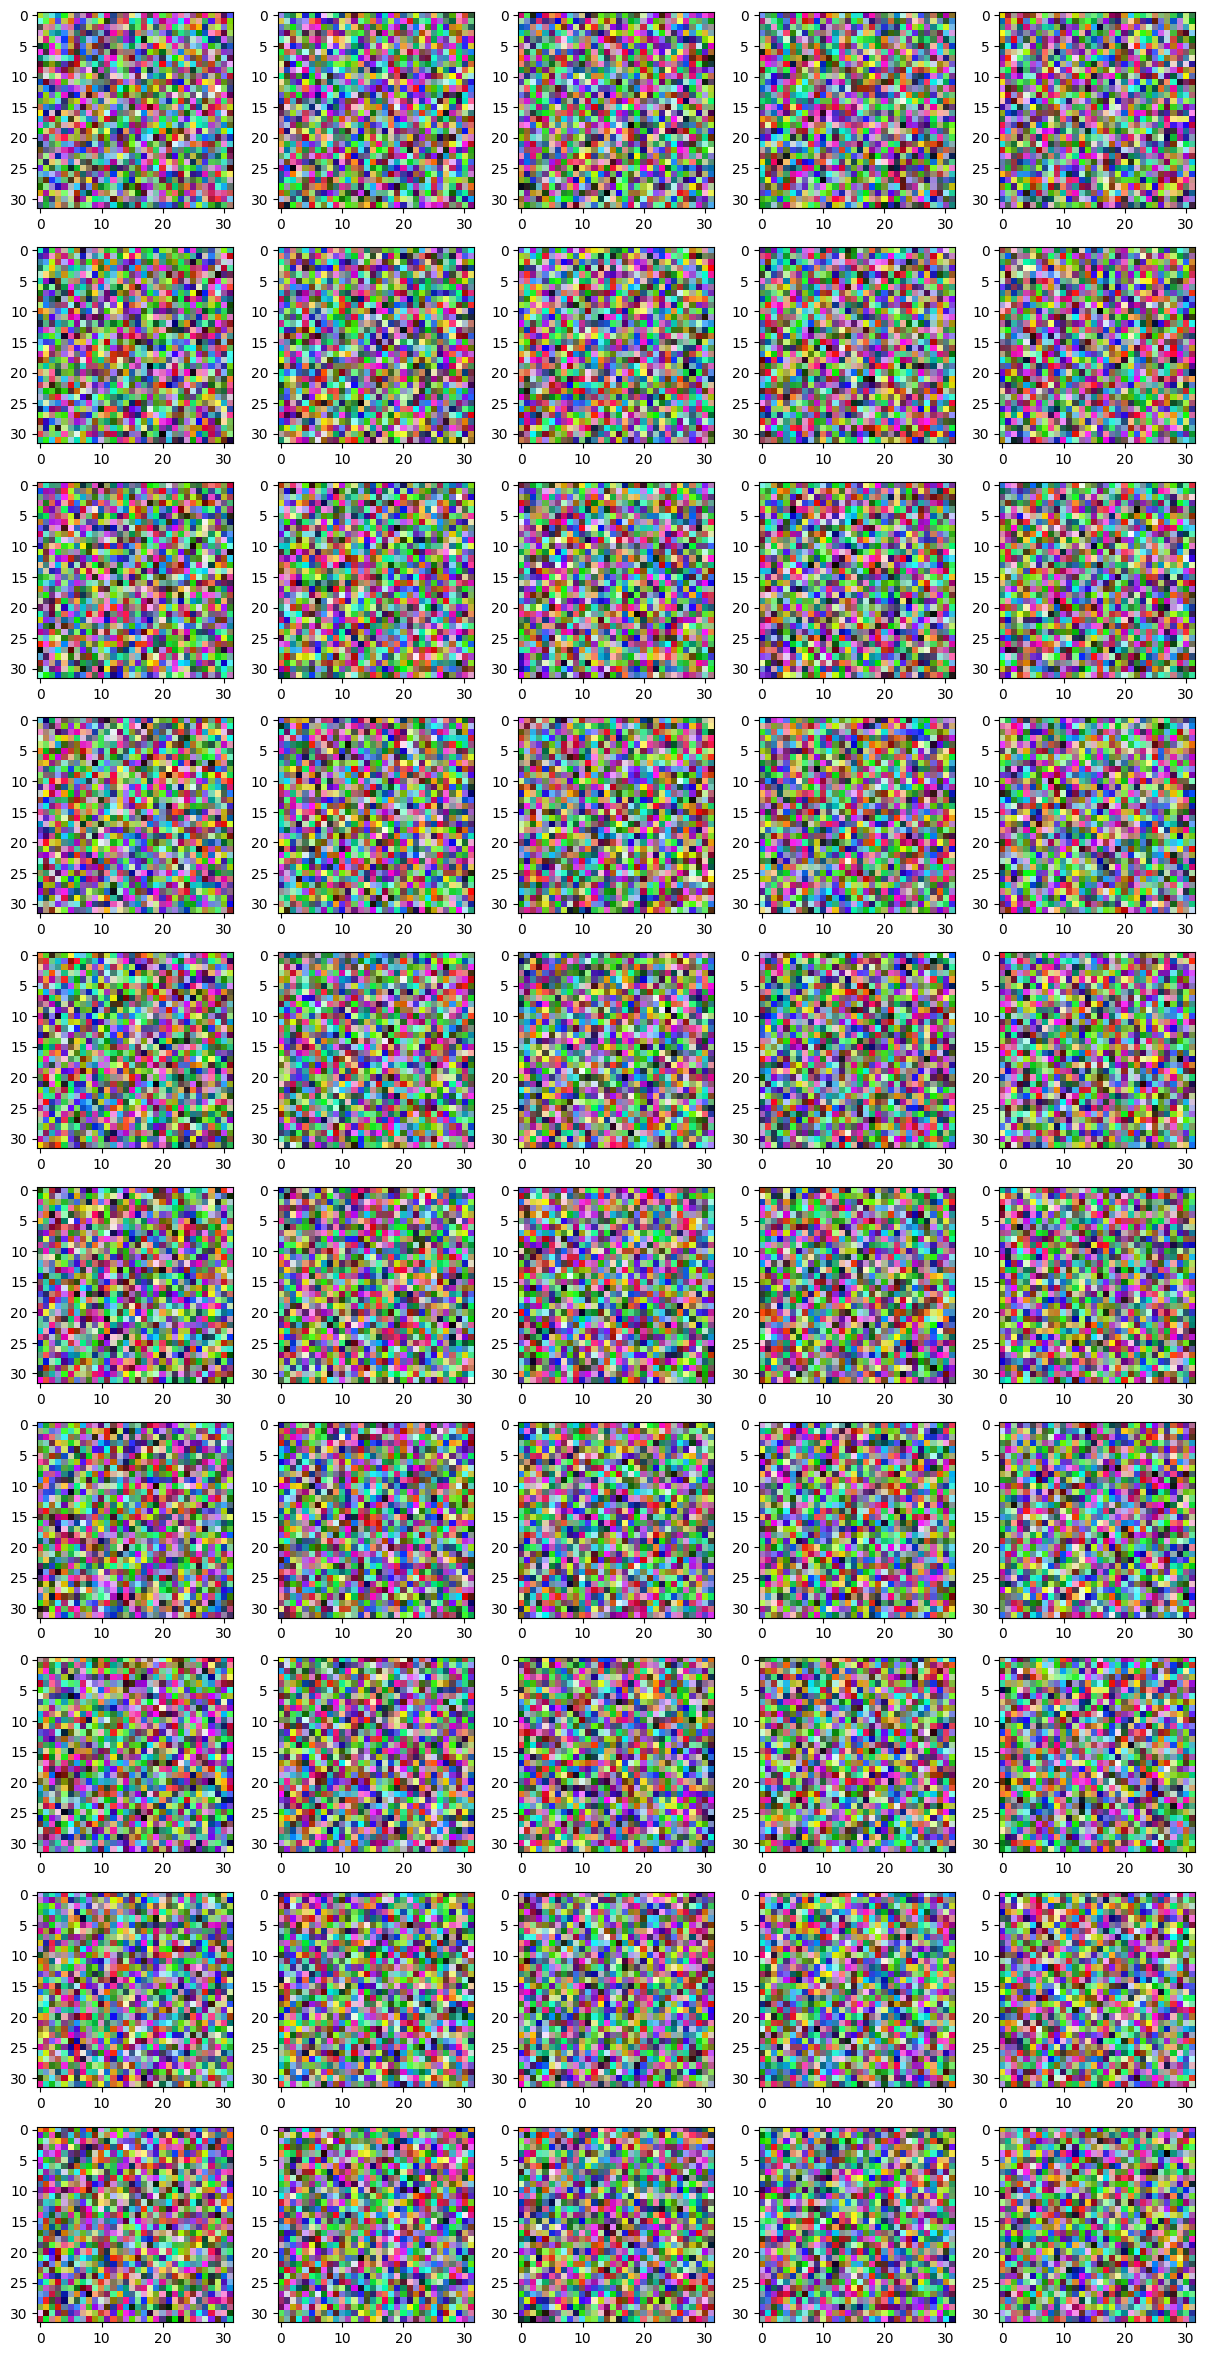

In [98]:
torch.manual_seed(16)

fig, axes = plt.subplots(10, 5, figsize=(15, 30))  # Create a 10x5 grid of subplots

for c in range(10):
    imgs = torch.randn((5, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        labels = torch.tensor([c] * 5).resize(5, 1).float().to(device)
        imgs = diffusion_model.backward(x=imgs, t=t, model=unet.eval().to(device), labels=labels)
    for idx, img in enumerate(imgs):
        axes[c, idx].imshow(reverse_transform(img))  # Access subplot using row, col indices

plt.show()

In [ ]:

BATCH_SIZE = 128
PRINT_FREQUENCY = 100

# Training loop (modified for batch processing)
for epoch in range(22):
    mean_epoch_loss = []
    avg_tr_loss = 0
    loop_train = tqdm(enumerate(data_loader, 1), total=len(data_loader), desc="Train", position=0, leave=True)

    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch_noisy, noise = diffusion_model.forward(data, t, device)
        predicted_noise = unet(batch_noisy, t)
        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        mean_epoch_loss.append(loss.item())
        avg_tr_loss += loss.item()
        loss.backward()
        optimizer.step()

        loop_train.set_description(f"Train - iteration : {epoch}")
        loop_train.set_postfix(
          avg_train_loss="{:.4f}".format(avg_tr_loss / index),
          refresh=True,
      )


  0%|          | 0/22 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

Train:   0%|          | 0/391 [00:00<?, ?it/s]

## Iteration Loss

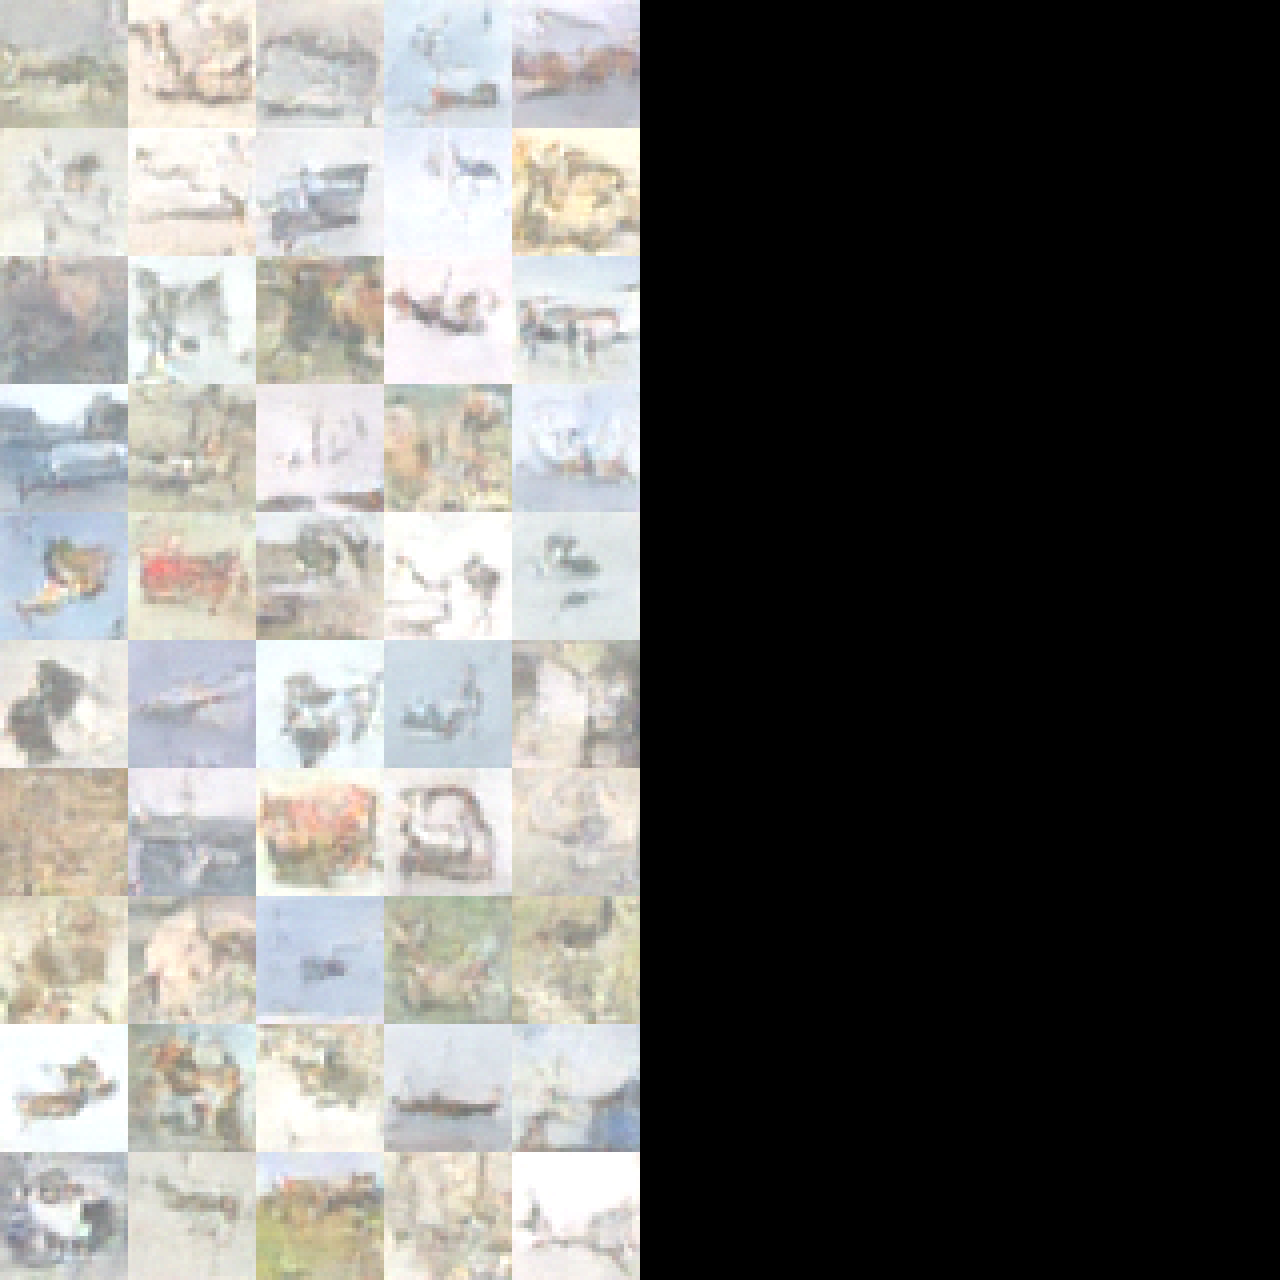

In [ ]:
ims = []
for i in range(200):
  ims.append(tensor_image(x[i].unsqueeze(0).cpu()))

image = Image.new('RGB', size=(32*10, 32*10))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 32*(i//10)))
image.resize((32*4*10, 32*4*10), Image.NEAREST)